# 1. Set up the notebook

Import modules.

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import display, IFrame, HTML

Create a random number generator (used for examples).

In [3]:
rng = np.random.default_rng()

Define a function to load flight data from hardware experiments and resample it at 100 Hz using linear interpolation, optionally discarding data from the start or end of your experiment.

In [4]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
        
    # return the resampled data
    return resampled_data

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [5]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

# 2. See an example of linear regression

Create example data.

In [19]:
# number of data points
n = 200

# sample c uniformly at random in [-2, 2]
c = rng.uniform(low=-2., high=2.),

# sample n values of x uniformly at random in [-10, 10]
x = rng.uniform(low=-10., high=10., size=n)

# sample each value of y from a normal distribution about
# the corresponding value of x
y = c * x + rng.standard_normal(size=n)

Apply least-squares linear regression to estimate $c$.

Note that `y * x` performs *arithmetic* multiplication *element-wise* - that is, it produces an array of the same size as `y` and `x` with the following elements:

```
[y[0] * x[0], y[1] * x[1], ...]
```

The same is true of `x**2` - it takes the square of each *element* of `x`.

In [20]:
c_est = np.sum(y * x) / np.sum(x**2)

Print the result. We expect `c_est` to be close to `c` but not exactly the same. We also expect `c_est` to be a better and better estimate as we increase the amount of data - **try increasing `n` and see what happens**.

In [21]:
print(f'    c = {c:6.3f}')
print(f'c_est = {c_est:6.3f}')

    c =  1.493
c_est =  1.494


Plot the result.

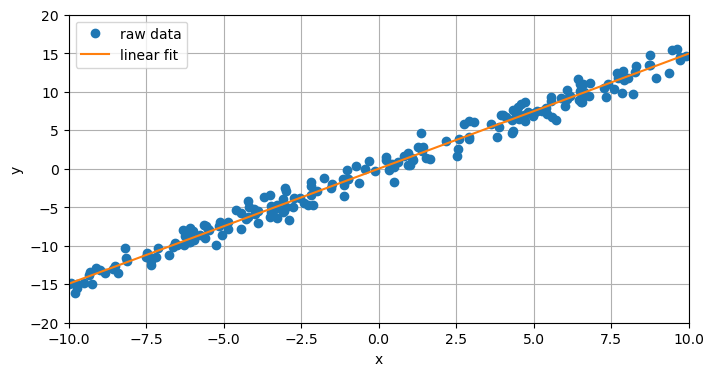

In [22]:
plt.figure(figsize=(8, 4))
plt.plot(x, y, '.', markersize=12, label='raw data')
plt.plot([-10, 10], [c_est * -10, c_est * 10], label='linear fit')
plt.xlim(-10, 10)
plt.xlabel('x')
plt.ylim(-20, 20)
plt.ylabel('y')
plt.grid()
plt.legend()

# 3. See an example of finite difference approximation

Create example data.

In [13]:
# time step
dt = 0.01

# array of t
t = np.linspace(0., 5., 1 + int(5 / dt))

# array of x(t)
x = np.sin(t)

# array of xdot(t)
xdot = np.cos(t)

Estimate $\dot{x}(t)$ by finite difference approximation.

Remember that, if there are `n` elements in `x`, then:

* `x[1:]` is the array `[x[1], x[2], ..., x[n-1]]`
* `x[:-1]` is the array `[x[0], x[1], ..., x[n-2]]`

So:

* `x[1:] - x[:-1]` is the array `[x[1] - x[0], x[2] - x[1], ..., x[n-1] - x[n-2]]`

In [14]:
xdot_est = (x[1:] - x[:-1]) / dt

Note that the length of `xdot_est` is one less than the length of `x`.

In [15]:
print(f'length of x is {len(x)}')
print(f'length of xdot_est is {len(xdot_est)}')

length of x is 501
length of xdot_est is 500


Plot $x(t)$, the true value of $\dot{x}(t)$, and our finite-difference estimate of $\dot{x}(t)$. Note that, because `xdot_est` has one fewer element than `x` and `t`, we need to plot `xdot_est` versus `t[:-1]` (i.e., all but the last element of `t`) rather than versus `t`.

(-1.5, 1.5)

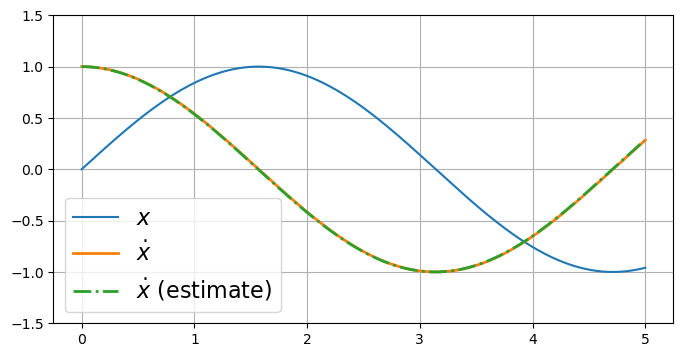

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(t, x, label='$x$')
plt.plot(t, xdot, linewidth=2, label='$\dot{x}$')
plt.plot(t[:-1], xdot_est, '-.', linewidth=2, label='$\dot{x}$ (estimate)')
plt.legend(fontsize=16)
plt.grid()
plt.ylim(-1.5, 1.5)

**Beware!** The finite difference approximation amplifies noise. Here is the result if we add a small amount of Gaussian noise to each sample of $x(t)$. Notice that $x(t)$ looks exactly the same as before, but the estimate of $\dot{x}(t)$ looks very noise (100 times noisier than $x(t)$).

(-1.5, 1.5)

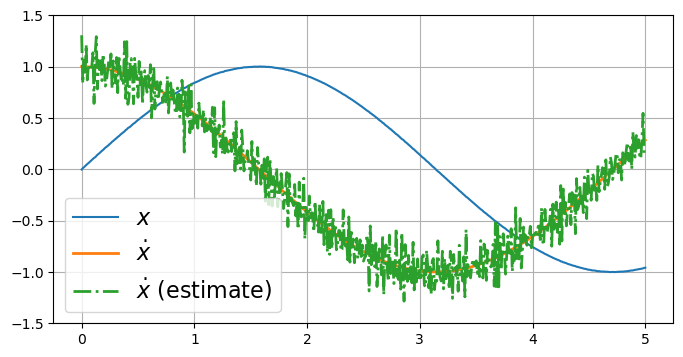

In [17]:
# create noisy data
x = np.sin(t) + 0.001 * rng.standard_normal(len(t))

# recompute estimate of xdot
xdot_est = (x[1:] - x[:-1]) / dt

# plot result
plt.figure(figsize=(8, 4))
plt.plot(t, x, label='$x$')
plt.plot(t, xdot, linewidth=2, label='$\dot{x}$')
plt.plot(t[:-1], xdot_est, '-.', linewidth=2, label='$\dot{x}$ (estimate)')
plt.legend(fontsize=16)
plt.grid()
plt.ylim(-1.5, 1.5)

# 4. Define constants

Define the acceleration of gravity in $\text{kg}\cdot\text{m} \;/\; \text{s}^2$:

In [18]:
g = 9.81

Define the mass of the drone in $\text{kg}$:

In [ ]:
m = 0.0316 # <-- FIXME

Define the principle moment of inertia about the $z$ axis in $\text{kg}\cdot\text{m}^2$:

In [ ]:
J_z = 2.70e-05 # <-- FIXME

Using a ruler, measure the distance $l$ in **meters** along both the $x$ and $y$ axis from the center of mass to the center of each rotor.

In [ ]:
l = 32/1000 # <-- FIXME

# 5. Find the force parameter

### 5.1 Show video of flight

In the following cell, show a video of your flight to collect data (change the url as appropriate).

In [ ]:
# FIXME (REPLACE URL TO SHOW A VIDEO OF YOUR FLIGHT)
mediaspace('https://mediaspace.illinois.edu/media/t/YOUR_VIDEO_ID')

Replace this cell with a precise description of the flight trajectory, both in words and (if you like) with a snippet of code from `flight.py`. You can include code in markdown with a "code block" that is delimited by three backslashes above and below - for example, this...

``````
```python
client.move(0.0, 0.0, 0.5, 0.0, 1.0)
```
``````
...is rendered like this:
```python
client.move(0.0, 0.0, 0.5, 0.0, 1.0)
```

### 5.2 Get and plot flight data

Load and resample data.

In [ ]:
data = load_hardware_data(
    'force-data.json',
    t_min_offset=0.,
    t_max_offset=0.,
)

Parse data to get:
* time
* the accelerometer measurements (**note!** these are in units of "g's")
* the motor power commands

In [ ]:
t = data['time']
a_x = g * data['acc.x']
a_y = g * data['acc.y']
a_z = g * data['acc.z']
m_1 = data['motor.m1']
m_2 = data['motor.m2']
m_3 = data['motor.m3']
m_4 = data['motor.m4']

Plot accelerometer measurements and motor power commands. Since the rotors generate force only in the body-fixed $z$ direction, the $x$ and $y$ accelerometer measurements should be much smaller than the $z$ accelerometer measurements. It is important to check this. (Also remember to use `t_min_offset` and `t_max_offset` so that you only look at data from when you are *actually flying.*)

In [ ]:
fig, (ax_a, ax_m) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
ax_a.plot(t, a_x, label='a_x')
ax_a.plot(t, a_y, label='a_y')
ax_a.plot(t, a_z, label='a_z')
ax_a.legend()
ax_a.grid()
ax_m.plot(t, m_1, label='m_1')
ax_m.plot(t, m_2, label='m_2')
ax_m.plot(t, m_3, label='m_3')
ax_m.plot(t, m_4, label='m_4')
ax_m.legend()
ax_m.grid()

### 5.3 Apply linear regression to estimate $k_F$

First, compute `x`.

In [ ]:
x = m_1 + m_2 + m_3 + m_4 #<-- FIXME (REPLACE WITH CODE TO DEFINE THE "X" IN LINEAR REGRESSION)

Second, compute `y`.

In [ ]:
y = m * [] # <-- FIXME (REPLACE WITH CODE TO DEFINE THE "Y" IN LINEAR REGRESSION)

Third, compute `c_est`.

In [ ]:
c_est = 0. # <-- FIXME (REPLACE WITH CODE TO COMPUTE THE ESTIMATE OF "C" IN LINEAR REGRESSION)

Finally, compute `k_F` in terms of `c_est`.

In [ ]:
k_F = 0. # <-- FIXME (REPLACE WITH CODE TO COMPUTE K_F GIVEN C_EST - LIKELY VERY SIMPLE!)

Show the estimate.

In [ ]:
print(f'k_F = {k_F:.2e}')

### 5.4 Validate your estimate

Compare the linear fit to the raw data.

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(x, y, '.', markersize=4, label='raw data')
plt.plot([0, 262140], [c_est * 0, c_est * 262140], label='linear fit')
plt.xlim(0, 262140)
plt.xlabel('x')
plt.ylim(0, 0.5)
plt.ylabel('y')
plt.grid()
plt.legend()

Compare the z-axis accelerometer measurement to what you would have predicted with your estimate of $k_F$.

In [ ]:
a_z_predicted = [] # <-- FIXME (REPLACE WITH CODE TO COMPUTE
                  #     THE ACCELEROMETER MEASUREMENTS, GIVEN
                  #     YOUR ESTIMATE OF K_F, THE MASS, AND THE
                  #     MOTOR POWER COMMANDS)

plt.figure(figsize=(12, 6))
plt.plot(t, a_z, label='a_z (measured)')
plt.plot(t, a_z_predicted, '--', label='a_z (predicted)')
plt.grid()
plt.legend()

# 6. Find the moment parameter

### 6.1 Show video of flight

In the following cell, show a video of your flight to collect data (change the url as appropriate).

In [ ]:
# FIXME (REPLACE URL TO SHOW A VIDEO OF YOUR FLIGHT)
mediaspace('https://mediaspace.illinois.edu/media/t/YOUR_VIDEO_ID')

Replace this cell with a precise description of the flight trajectory, both in words and (if you like) with a snippet of code from `flight.py`. You can include code in markdown with a "code block" that is delimited by three backslashes above and below - for example, this...

``````
```python
client.move(0.0, 0.0, 0.5, 0.0, 1.0)
```
``````
...is rendered like this:
```python
client.move(0.0, 0.0, 0.5, 0.0, 1.0)
```

### 6.2 Get and plot flight data

Load and resample data.

In [ ]:
data = load_hardware_data(
    'moment-data.json',
    t_min_offset=0.,
    t_max_offset=0.,
)

Parse data to get:
* time
* the gyroscope measurements (**note!** these are in units of degrees / second)
* the motor power commands

In [ ]:
t = data['time']
w_x = np.deg2rad(data['gyro.x'])
w_y = np.deg2rad(data['gyro.y'])
w_z = np.deg2rad(data['gyro.z'])
m_1 = data['motor.m1']
m_2 = data['motor.m2']
m_3 = data['motor.m3']
m_4 = data['motor.m4']

Find the time step. It should be `0.01` because data were sampled at 100 Hz.

In [ ]:
dt = t[1] - t[0]
print(f'dt = {dt}')

Plot gyroscope measurements and motor power commands. Since the drone was near hover during flight (only yawing back and forth), the $x$ and $y$ gyroscope measurements should be much smaller than the $z$ gyroscope measurements. It is important to check this. (Also remember to use `t_min_offset` and `t_max_offset` so that you only look at data from when you are *actually flying.*)

In [ ]:
fig, (ax_w, ax_m) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
ax_w.plot(t, w_x, label='w_x')
ax_w.plot(t, w_y, label='w_y')
ax_w.plot(t, w_z, label='w_z')
ax_w.legend()
ax_w.grid()
ax_m.plot(t, m_1, label='m_1')
ax_m.plot(t, m_2, label='m_2')
ax_m.plot(t, m_3, label='m_3')
ax_m.plot(t, m_4, label='m_4')
ax_m.legend()
ax_m.grid()

### 6.3 Use finite difference to estimate $\dot{w}_z$

Estimate $\dot{w}_z$ by finite difference.

In [ ]:
w_z_dot = [] # <-- FIXME (REPLACE WITH CODE TO COMPUTE W_Z BY FINITE DIFFERENCE)

Plot both $w_z$ and $\dot{w}_z$.

**This code, unmodified, will result in an error!** This is because `w_z_dot` has one fewer element than `w_z` and `t`. Do you remember what you need to change? Fix it.

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(t, w_z, label='$w_z$')
plt.plot(t, w_z_dot, '--', label='$\dot{w}_z$')
plt.grid()
plt.legend(fontsize=16)

### 6.4 Apply linear regression to estimate $k_M$

First, compute `x`.

In [ ]:
x = [] # <-- FIXME (REPLACE WITH CODE TO DEFINE THE "X" IN LINEAR REGRESSION)

Second, compute `y`.

In [ ]:
y = [] # <-- FIXME (REPLACE WITH CODE TO DEFINE THE "Y" IN LINEAR REGRESSION)

Third, compute `c_est`.

**If you do this without thinking, you will get an error!** In particular, you will likely see something like this:

```
ValueError: operands could not be broadcast together with shapes (1313,) (1314,)
```

The reason for this error is that you are trying to add, subtract, multiply, or divide (element-wise) two 1D numpy arrays that have different lengths. Remember, in particular, that `w_z_dot` has one fewer element than everything else. What will you need to change in order to make your code work without error?

In [ ]:
c_est = 0. # <-- FIXME (REPLACE WITH CODE TO COMPUTE THE ESTIMATE OF "C" IN LINEAR REGRESSION)

Finally, compute `k_M` in terms of `c_est`.

In [ ]:
k_M = 0. # <-- FIXME (REPLACE WITH CODE TO COMPUTE K_M GIVEN C_EST - LIKELY VERY SIMPLE!)

Show the estimate.

In [ ]:
print(f'k_M = {k_M:.2e}')

### 6.4 Validate your estimate

Compare the linear fit to the raw data.

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(x, y, '.', markersize=12, label='raw data')
plt.plot([-131070, 131070], [c_est * -131070, c_est * 131070], label='linear fit')
plt.xlim(-131070, 131070)
plt.xlabel('x')
plt.ylim(-.002, 0.002)
plt.ylabel('y')
plt.grid()
plt.legend()

Compare the finite-difference estimate of $\dot{w}_z$ to what you would have predicted using $k_M$. **Again, you will likely have to modify this code for it to execute without error - be careful about the lengths of your arrays!**

In [ ]:
w_z_dot_predicted = [] # <-- FIXME (REPLACE WITH CODE TO COMPUTE
                       #     W_Z_DOT AS PREDICTED FROM YOUR ESTIMATE
                       #     OF K_F, THE MOMENT OF INERTIA J_Z, AND
                       #     THE MOTOR POWER COMMANDS)

plt.figure(figsize=(12, 6))
plt.plot(t, w_z_dot, label='$\dot{w}_z$ (measured)')
plt.plot(t, w_z_dot_predicted, '--', label='$\dot{w}_z$ (predicted)')
plt.grid()
plt.legend()

# 7. Summarize and discuss the results

### Summary of results

In [ ]:
print(f'l = {l:.2} m')
print(f'k_F = {k_F:.2e}')
print(f'k_M = {k_M:.2e}')

### Sources of error

**Modify the text in this cell** to discuss possible sources of error. For example:
* How uncertain was each measurement and each computed quantity?
* What assumptions were made and to what extent were these assumptions violated?
* Are there ways in which either the experiments or the analysis could be improved?